In [39]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For data normalization
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt

# For pose detection
from ultralytics import YOLO

# For softmax
from scipy.special import softmax

# For counting classes
from collections import Counter


In [40]:
import os
import json
import numpy as np

# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for segment in data["segments"].values():
            for annotation in segment["annotations"]:
                keypoints = annotation["keypoints"]
                if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                    print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                    continue

                # Extract x, y coordinates only and flatten
                normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

                # Pad or truncate to ensure consistent length
                if len(normalized_keypoints) < expected_num_keypoints:
                    normalized_keypoints = np.pad(
                        normalized_keypoints,
                        (0, expected_num_keypoints - len(normalized_keypoints)),
                        mode="constant"
                    )
                elif len(normalized_keypoints) > expected_num_keypoints:
                    normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

                X.append(normalized_keypoints)
                y.append(label)
    
    return np.array(X), np.array(y)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

Feature matrix shape: (17597, 34)
Labels array shape: (17597,)


              precision    recall  f1-score   support

           0       0.90      0.95      0.92       469
           1       0.88      0.87      0.87       381
           2       0.94      0.91      0.93       343
           3       0.92      0.91      0.92       416
           4       0.96      0.97      0.97       394
           5       0.91      0.94      0.92       431
           6       0.94      0.94      0.94       533
           7       0.92      0.85      0.88       257
           8       0.92      0.89      0.91       296

    accuracy                           0.92      3520
   macro avg       0.92      0.91      0.92      3520
weighted avg       0.92      0.92      0.92      3520



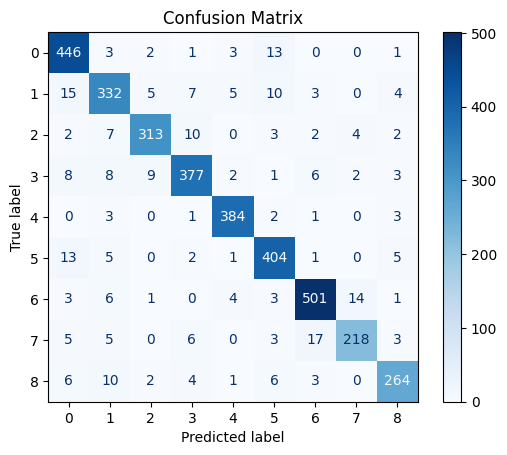

In [41]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Train the model on the scaled training data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred = clf.predict(X_test_scaled)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Class distribution in dataset: {np.int64(0): np.int64(2346), np.int64(1): np.int64(1903), np.int64(2): np.int64(1717), np.int64(3): np.int64(2079), np.int64(4): np.int64(1969), np.int64(5): np.int64(2152), np.int64(6): np.int64(2665), np.int64(7): np.int64(1284), np.int64(8): np.int64(1482)}
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       469
           1       0.88      0.87      0.87       381
           2       0.94      0.91      0.93       343
           3       0.92      0.91      0.92       416
           4       0.96      0.97      0.97       394
           5       0.91      0.94      0.92       431
           6       0.94      0.94      0.94       533
           7       0.92      0.85      0.88       257
           8       0.92      0.89      0.91       296

    accuracy                           0.92      3520
   macro avg       0.92      0.91      0.92      3520
weighted avg       0.92      0.92      0.92      3520



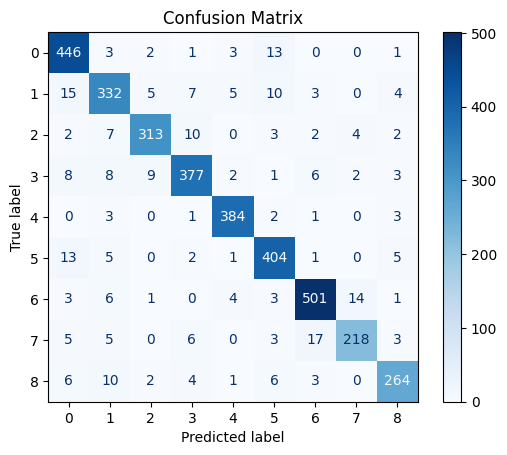

In [34]:
# Initialize the scaler
scaler = MinMaxScaler()

#Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution in dataset:", dict(zip(unique, counts)))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Reverse mapping of exercise labels
exercise_labels_inv = {v: k for k, v in exercise_labels.items()}


In [43]:
def extract_keypoints_and_predict(frame, model, clf, scaler):
    # Run the YOLO pose model
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        return None, None  # Skip if no keypoints detected
    
    # Initialize variables to store the keypoints of the largest person
    largest_area = 0
    selected_keypoints = None

    for result in results:
        if result.keypoints is not None and result.boxes is not None and len(result.boxes) > 0:
            keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # x, y coordinates
            bbox = result.boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
            x_min, y_min, x_max, y_max = bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            area = bbox_width * bbox_height

            if area > largest_area:
                largest_area = area
                selected_keypoints = keypoints.flatten()

    if selected_keypoints is None:
        return None, None

    # Check if the number of keypoints matches the expected number
    expected_num_features = scaler.n_features_in_
    if selected_keypoints.size != expected_num_features:
        print(f"Expected {expected_num_features} features, but got {selected_keypoints.size} features")
        return None, None

    # Normalize keypoints
    normalized_keypoints = scaler.transform([selected_keypoints])

    # Predict class and probabilities
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores if not already probabilities
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    return exercise_class[0], exercise_class_proba[0]


In [44]:
import cv2



model = YOLO("yolov8s-pose.pt")  # Replace with your model path if different
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hoogspringen/segment_000001.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")



0: 384x640 1 person, 89.6ms
Speed: 1.9ms preprocess, 89.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.1ms
Speed: 0.6ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 75.0ms
Speed: 0.7ms preprocess, 75.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.2ms
Speed: 1.1ms preprocess, 79.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.0ms
Speed: 0.6ms preprocess, 87.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 86.9ms
Speed: 0.9ms preprocess, 86.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 77.4ms
Speed: 0.8ms preprocess, 77.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.3ms
Speed: 0.6ms preprocess, 74.3ms inference, 0.4ms postprocess per image at shape (1, 3, 38

In [45]:
from collections import Counter
import numpy as np
from scipy.special import softmax

# Assuming the necessary imports and definitions for YOLO, extract_keypoints_and_predict, clf, scaler, and exercise_labels_inv are already done

model = YOLO("yolov8s-pose.pt")  # Replace with your model path if different
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_001557.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")

    # Predicting the score based on the average probabilities
    predicted_score = np.dot(average_probabilities, np.arange(len(class_labels)))
    print(f"\nPredicted Score: {predicted_score:.2f}")


0: 640x640 1 person, 144.6ms
Speed: 4.2ms preprocess, 144.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 131.7ms
Speed: 1.3ms preprocess, 131.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 135.2ms
Speed: 1.2ms preprocess, 135.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 134.8ms
Speed: 1.4ms preprocess, 134.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 134.6ms
Speed: 1.5ms preprocess, 134.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 133.7ms
Speed: 1.2ms preprocess, 133.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 219.1ms
Speed: 1.4ms preprocess, 219.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 141.5ms
Speed: 1.2ms preprocess, 141.5ms inference, 0.5ms postprocess per image at

In [51]:
from collections import Counter
import numpy as np
from scipy.special import softmax
import cv2  # OpenCV for video processing
from ultralytics import YOLO  # YOLOv8 library

# Load the YOLOv8 pose model
model = YOLO("yolov8s-pose.pt")  # Replace with your model path

# Assuming clf, scaler, and exercise_labels_inv are pre-defined
# clf: The classifier used for exercise classification
# scaler: Scaler used to preprocess keypoints before classification
# exercise_labels_inv: Mapping from class indices to class names

def extract_keypoints_and_predict(frame, model, clf, scaler):
    """
    Process a frame, detect keypoints, and predict exercise class and probabilities.
    """
    # Detect keypoints using YOLO model
    results = model(frame)  # YOLO inference
    if not results:
        raise ValueError("No detections made in the frame.")
    
    # Extract keypoints from the results
    keypoints_list = []
    for result in results:
        if hasattr(result, "keypoints") and result.keypoints is not None:
            # Extract raw keypoint data (xy coordinates)
            keypoints = result.keypoints.xy.cpu().numpy()  # Ensure NumPy array on CPU
            keypoints_list.append(keypoints)
    
    if not keypoints_list:
        raise ValueError("No keypoints detected in frame.")
    
    # Use the first set of keypoints (or implement logic to handle multiple detected poses)
    keypoints = keypoints_list[0]  # Assuming only one person per frame

    # Preprocess keypoints (scaling and reshaping for the classifier)
    keypoints_flattened = keypoints.flatten()  # Flatten to a 1D array
    scaled_keypoints = scaler.transform([keypoints_flattened])  # Scale and reshape
    probabilities = clf.predict_proba(scaled_keypoints)[0]
    predicted_class = np.argmax(probabilities)
    return predicted_class, probabilities

# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_001557.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        # Resize the frame for faster processing
        frame_resized = cv2.resize(frame, (640, 640))
        
        # Call the updated function
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame_resized, model, clf, scaler)
        
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")

    # Predicting the weighted score based on the average probabilities
    weighted_probs = np.multiply(average_probabilities, np.arange(len(class_labels)))
    predicted_score = np.sum(weighted_probs) / np.sum(average_probabilities)
    print(f"\nWeighted Predicted Score: {predicted_score:.2f}")



0: 640x640 1 person, 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 127.6ms
Speed: 0.9ms preprocess, 127.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 138.7ms
Speed: 1.2ms preprocess, 138.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 128.8ms
Speed: 0.9ms preprocess, 128.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 120.0ms
Speed: 1.1ms preprocess, 120.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 121.9ms
Speed: 0.8ms preprocess, 121.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 123.1ms
Speed: 0.8ms preprocess, 123.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 127.0ms
Speed: 0.9ms preprocess, 127.0ms inference, 0.4ms postprocess per image at